# Starbucks Capstone Project  - Customer Segmentation



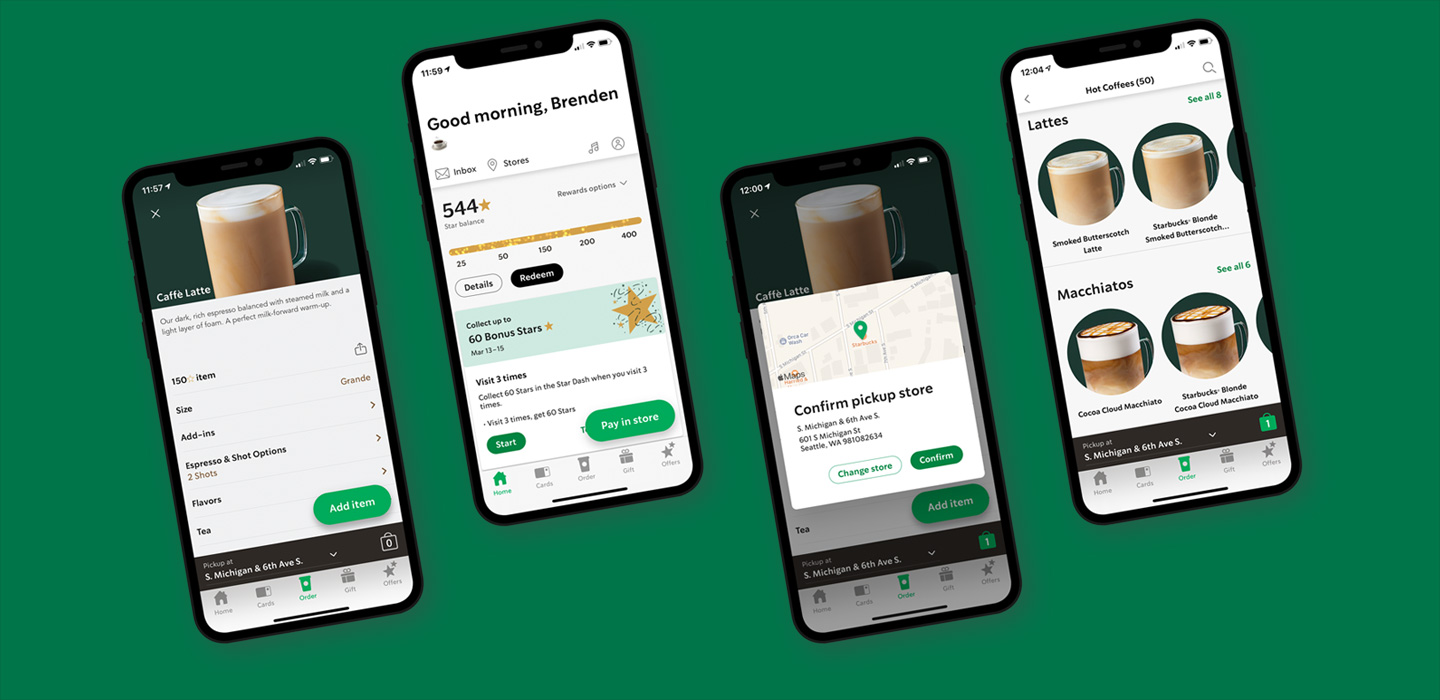

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.


### Goal: Perform Demographic & Value-based customer segmentation

- Create groups with unsupervised clustering method
    - Demographic (age, sex) & account information (account age, income)
    - Consider customer behavior during times of no promotion as their normal behavior (amount of visits & average amount spent per visit) in the clustering
    
- Calculate impact of promotion depending on each type of promotional item



# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



## Part I. Importing Libraries & Reading Data 

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib
% matplotlib inline
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer

import seaborn as sns

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Part II. Explorative Data Analysis 

In [2]:
#portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
portfolio.head(5)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


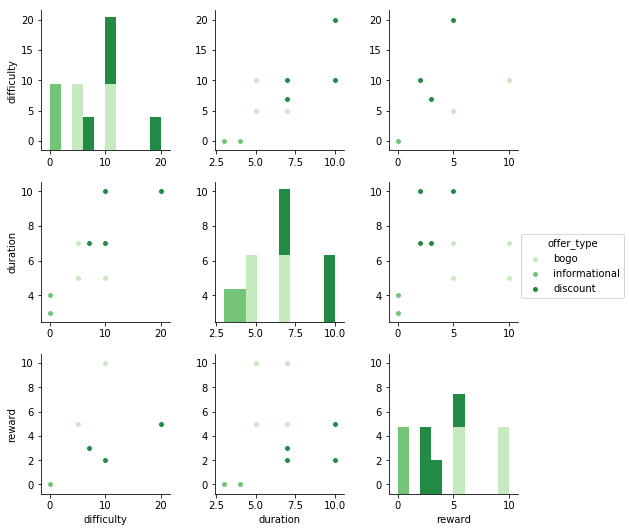

In [3]:
sns.pairplot(portfolio, hue='offer_type', palette='Greens');

In [4]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [5]:
#Explore portfolio data
portfolio['duration'].describe()

count    10.000000
mean      6.500000
std       2.321398
min       3.000000
25%       5.000000
50%       7.000000
75%       7.000000
max      10.000000
Name: duration, dtype: float64

In [6]:
#Explore portfolio data
portfolio['difficulty'].describe()

count    10.000000
mean      7.700000
std       5.831905
min       0.000000
25%       5.000000
50%       8.500000
75%      10.000000
max      20.000000
Name: difficulty, dtype: float64

In [7]:
#Explore offer_types
portfolio.groupby(by = 'offer_type').count()['id']

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [8]:
#profile.json - demographic data for each customer
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


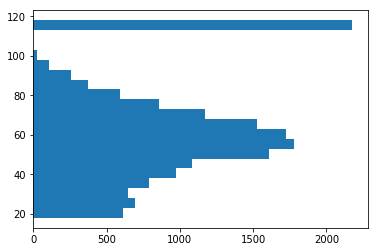

In [9]:
#Plot age distribution

plt.hist(profile['age'], orientation='horizontal', bins = 20);


In [10]:
#Min/Max statistics for age distribution
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [11]:
#transcript.json - records for transactions, offers received, offers viewed, and offers completed
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [12]:
#Explore event types
transcript.groupby(by = 'event').count()['value']

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: value, dtype: int64

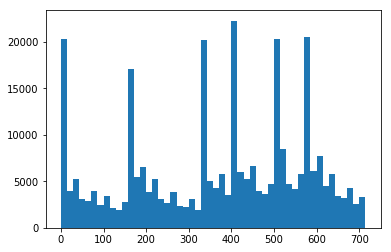

In [13]:
#Visualize transcript dataframe transactions&events over time
plt.hist(transcript['time'], bins=50, label=transcript['time']);

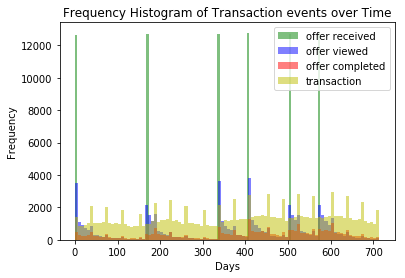

In [14]:
#Create bar bar graph visualization separated for each type of transaction event
x1 = transcript.loc[transcript.event=='offer received', 'time']
x2 = transcript.loc[transcript.event=='offer viewed', 'time']
x3 = transcript.loc[transcript.event=='offer completed', 'time']
x4 = transcript.loc[transcript.event=='transaction', 'time']

kwargs = dict(alpha=0.5, bins=100, stacked=True)

plt.hist(x1, **kwargs, color='g', label='offer received')
plt.hist(x2, **kwargs, color='b', label='offer viewed')
plt.hist(x3, **kwargs, color='r', label='offer completed')
plt.hist(x4, **kwargs, color='y', label='transaction')
plt.gca().set(title='Frequency Histogram of Transaction events over Time', ylabel='Frequency', xlabel='Days')

plt.legend();

In [15]:
#Take only transactions from transcript dataframe to isolate transactions incl. dollar amount
transactions = transcript.loc[transcript['event'] == 'transaction']
transactions.head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [16]:
#TESTING Remove later
test = transcript[transcript['person'] == '0009655768c64bdeb2e877511632db8f']
test

,event,person,time,value
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16}
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
168412,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57}
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
204340,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


In [17]:
#Take only offer_interactions from transcript dataframe to isolate events incl. offer_id
offers_interact = transcript.loc[transcript['event'] != 'transaction']
offers_interact.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


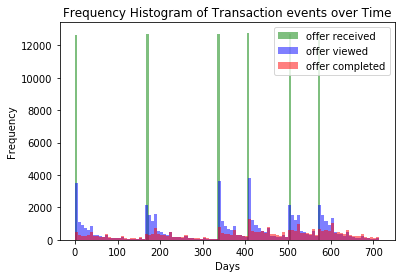

In [18]:
#Create bar bar graph visualization separated for each type of transaction event
y1 = offers_interact.loc[offers_interact.event=='offer received', 'time']
y2 = offers_interact.loc[offers_interact.event=='offer viewed', 'time']
y3 = offers_interact.loc[offers_interact.event=='offer completed', 'time']

kwargs = dict(alpha=0.5, bins=100, stacked=True)

plt.hist(y1, **kwargs, color='g', label='offer received')
plt.hist(y2, **kwargs, color='b', label='offer viewed')
plt.hist(y3, **kwargs, color='r', label='offer completed')
plt.gca().set(title='Frequency Histogram of Transaction events over Time', ylabel='Frequency', xlabel='Days')

plt.legend();

### Key Insights from explorative data analysis

#### Portfolio
- One promotion is communicated through multiple channels (web, email, mobile, social)	
- A new feature could be created to distinguish between 'social' or 'non-social' promotions
- The duration ranges from 3 to 10 days
- The difficulty ranges from $\$$0 to $\$$20 
- The reward ranges from $\$$0 (purely information) to $\$$10 (bogo: Buy one get one free)

#### Profile
- Age groups range from 18 to 100. Another larger amonut of profiles have age 118, which could be underage or unknown age
- Further investigation shows that age 118 corresponds to missing data in income & gender columns as well
- Column 'became_member_on' needs to be transformed to date-time data type, from there an 'account age' feature can be created

#### Transcripts 
- Four events types available (Offer received, Offer viewed, Offer completed, Transaction) 
- Time shows spikes on certain number of days passed (not normal or evenly distributed)
- Closer inspection shows that transaction data spikes are due to offers received on same days
- Value column contains offer_id, but must be cleaned. Example: {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}

## Part III. Hypothesis & Metrics

### Hypothesis 1:
**H0:** There are no hidden groups of similar customers in the dataset.

**H1:** There are hidden groups/clusters of similar customers in the dataset.

**Metric 1:** To judge if there are groups within the customer dataset an unsupervised clustering will be attempted. As the initial model a k-means clustering model is used. To choose the hyperparameter 'number of clusters' the Silhouette Score is calculated, visualized and the optimal number is chosen.

### Hypothesis 2:
**H0:** The identified clusters are responding indifferently to the available promotional offer types.

**H1:** The identified clusters are responding differently to the available promotional offer types.

**Metric 2:** To test Hypothesis 2 the spending habits of all customers during promotions are analyzed, compared to each other and within themselves to their normal spending habits. The key metrics are average amount spent per visit, average visits per week and total amount spent per week. The results shall be visualized and interpreted.

## Part IV. Data transformation

### Transforming Portfolio data

In [19]:
portfolio.head(5)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [20]:
#
mlb = MultiLabelBinarizer()
mlb.fit(portfolio['channels'])
mat = mlb.transform(portfolio['channels'])

portfolio = pd.concat([portfolio, pd.DataFrame(mat)], axis=1)

portfolio.columns = ['channels', 'difficulty', 'duration', 'id', 'offer_type', 'reward', 'email', 'mobile', 'social', 'web']
portfolio = portfolio.drop(columns='channels')

In [21]:
#Setting id as index
portfolio.set_index('id', drop=True, append=False, inplace=True)

In [22]:
portfolio.head()

,difficulty,duration,offer_type,reward,email,mobile,social,web
id,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,7,bogo,10,1,1,1,0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,bogo,10,1,1,1,1
3f207df678b143eea3cee63160fa8bed,0,4,informational,0,1,1,0,1
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,0,1
0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,0,0,1


### Transforming Profile data

In [23]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [24]:
#2175 Rows contain missing profile information
#These could be removed or filled with e.g. 0 value 

#profile = profile[profile['income'].notna()]
values = {"gender": "NA", "income": 0}

profile = profile.fillna(value=values)
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,NA,68be06ca386d4c31939f3a4f0e3dd783,0.0
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,NA,38fe809add3b4fcf9315a9694bb96ff5,0.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,NA,a03223e636434f42ac4c3df47e8bac43,0.0


In [25]:
#Change became_member_on datatype integer to DateTime with custom lamda function
profile['DateTime'] = profile['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))



In [26]:
#Oldest account within the dataset
profile['DateTime'].min()

Timestamp('2013-07-29 00:00:00')

In [27]:
#Creating a new feature account_age 
#Definition: The time difference in days from when each account was created to the oldest account
#Idea: The age of the account could indicate something about the customer and could have an influence on their preferences

profile['account_age'] = (profile['DateTime'] - profile['DateTime'].min()).dt.days

In [28]:
profile_subset = profile[['id', 'age', 'gender','income','account_age']]
profile_subset.head()

,id,age,gender,income,account_age
0,68be06ca386d4c31939f3a4f0e3dd783,118,NA,0.0,1294
1,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,1447
2,38fe809add3b4fcf9315a9694bb96ff5,118,NA,0.0,1809
3,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,1380
4,a03223e636434f42ac4c3df47e8bac43,118,NA,0.0,1467


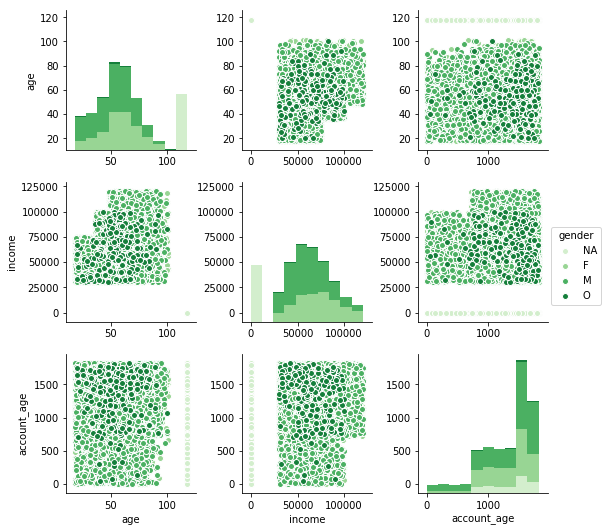

In [29]:
sns.pairplot(profile_subset, hue='gender', palette='Greens');

In [30]:

#One hot encoding of gender column
one_hot = pd.get_dummies(profile_subset['gender'])

# Drop column gender as it is now encoded
profile_subset = profile_subset.drop('gender',axis = 1)

# Join the encoded df
profile_subset = profile_subset.join(one_hot)
profile_subset.head(5)
    


,id,age,income,account_age,F,M,NA,O
0,68be06ca386d4c31939f3a4f0e3dd783,118,0.0,1294,0,0,1,0
1,0610b486422d4921ae7d2bf64640c50b,55,112000.0,1447,1,0,0,0
2,38fe809add3b4fcf9315a9694bb96ff5,118,0.0,1809,0,0,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1380,1,0,0,0
4,a03223e636434f42ac4c3df47e8bac43,118,0.0,1467,0,0,1,0


In [31]:
#Setting id as index
profile_subset.set_index('id', drop=True, append=False, inplace=True)

In [32]:
profile_subset.head(5)

,age,income,account_age,F,M,NA,O
id,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,118,0.0,1294,0,0,1,0
0610b486422d4921ae7d2bf64640c50b,55,112000.0,1447,1,0,0,0
38fe809add3b4fcf9315a9694bb96ff5,118,0.0,1809,0,0,1,0
78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1380,1,0,0,0
a03223e636434f42ac4c3df47e8bac43,118,0.0,1467,0,0,1,0


### Transforming Transcript data

#### Extract and transform transactions from transcript data

In [33]:
transactions.head(5)

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [34]:
#Explode value column for dollar amount spent- ignore warning
pd.options.mode.chained_assignment = None  # default='warn'
id_column_t = transactions['value'].apply(pd.Series)
transactions['amount'] = id_column_t['amount']
transactions.drop(columns = 'value', inplace = True)
transactions.head(5)

,event,person,time,amount
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [35]:
#Sorting events in decending order by offer_id & person and dropping transactions without value amount
transactions.sort_values(by=['person'], ascending=True).dropna(subset=['amount'], inplace = True);

In [36]:
transactions.head(5)

,event,person,time,amount
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


#### Extract and transform offers from transcript data

In [37]:
offers_interact.head(5)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [38]:
#Explode value column for offer ids- ignore warning
pd.options.mode.chained_assignment = None  # default='warn'
id_column = offers_interact['value'].apply(pd.Series)

#transactions.drop(columns = 'value', inplace = True)


In [39]:
#Combine two different spellings of offer id and offer_id
id_column['offer_id'].fillna(id_column['offer id'], inplace=True)
offers_interact['offer_id'] = id_column['offer_id']
offers_interact['reward'] = id_column['reward']
offers_interact.drop(columns = 'value', inplace = True)

In [40]:
offers_interact.head(5)

,event,person,time,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [41]:
#Sort dataframe
offers_interact = offers_interact.sort_values([ 'person', 'offer_id', 'time'], ascending = (True, True, True))
offers_interact.head(5)

,event,person,time,offer_id,reward
247879,offer received,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,NaN
258884,offer completed,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,2.0
113605,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,NaN
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,NaN
55972,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,NaN


In [42]:
#TESTING Remove later
test = offers_interact[offers_interact['person'] == '00116118485d4dfda04fdbaba9a87b5c']
test

,event,person,time,offer_id,reward
56475,offer received,00116118485d4dfda04fdbaba9a87b5c,168,f19421c1d4aa40978ebb69ca19b0e20d,NaN
85769,offer viewed,00116118485d4dfda04fdbaba9a87b5c,216,f19421c1d4aa40978ebb69ca19b0e20d,NaN
248359,offer received,00116118485d4dfda04fdbaba9a87b5c,576,f19421c1d4aa40978ebb69ca19b0e20d,NaN
284472,offer viewed,00116118485d4dfda04fdbaba9a87b5c,630,f19421c1d4aa40978ebb69ca19b0e20d,NaN


In [43]:
#Reset index
offers_interact.reset_index(inplace = True, drop = True)
offers_interact.head(5)

,event,person,time,offer_id,reward
0,offer received,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,NaN
1,offer completed,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,2.0
2,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,NaN
3,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,NaN
4,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,NaN


In [44]:

#Function - Creates index column with same rank for one person / offer in order of time starting at 1. 
#Same offer can be applied to same person multiple times, therefore the event column is checked to distinguish between multiple events once the offer is received again it is handeled as a new offer and therefor the rank counts up one
#First row event must be an offer received

#Instantiate ranks and variables
group_indx = []
rank = 0

event_ar = offers_interact['event']
prev_value = 0 

#Loop through dataframe to check for same person & offer and give indexes bases 
for t in event_ar:
     
    #check if event is received and if previous was also received (first row should be 1 - only count one up after first row)
    #if t == 'offer received' and prev_value == 'offer received':
    #    group_indx += [rank]
    #    prev_value = t
    #    rank += 1
    
    # otherwise add index and count one up, refresh previous value
    if t == 'offer received':
        rank += 1
        group_indx += [rank]
        prev_value = t
    
    # otherwise add index and keep index same, refresh previous value
    else:
        group_indx += [rank]
        prev_value = t

        

In [45]:
#Join new grouped_index to offers dataframe
offers_interact['indx'] = group_indx
offers_interact.head(5)

,event,person,time,offer_id,reward,indx
0,offer received,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,NaN,1
1,offer completed,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,2.0,1
2,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,NaN,2
3,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,NaN,2
4,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,NaN,3


In [46]:
#Create a grouped data frame of all offers for each person
grouped_offers = offers_interact.groupby(by = ['person','offer_id','indx','event']).min()
grouped_offers.head(5)


time  \
person                           offer_id                         indx event                   
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 1    offer completed   576   
                                                                       offer received    576   
                                 3f207df678b143eea3cee63160fa8bed 2    offer received    336   
                                                                       offer viewed      372   
                                 5a8bc65990b245e5a138643cd4eb9837 3    offer received    168   

                                                                                        reward  
person                           offer_id                         indx event                    
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 1    offer completed     2.0  
                                                                       offer received      NaN  
                                 3f207df678b143eea3cee63160fa8bed 2    offer received      NaN  
                                                                       offer viewed        NaN  
                                 5a8bc65990b245e5a138643cd4eb9837 3    offer received      NaN

In [47]:
#Create new dataframe sub_offers to unstack the events and times in separate columns
unstacked_offers = grouped_offers['time']
unstacked_offers = unstacked_offers.unstack('event')
unstacked_offers.head()

event                                                                   offer completed  \
person                           offer_id                         indx                    
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 1               576.0   
                                 3f207df678b143eea3cee63160fa8bed 2                 NaN   
                                 5a8bc65990b245e5a138643cd4eb9837 3                 NaN   
                                 f19421c1d4aa40978ebb69ca19b0e20d 4               414.0   
                                 fafdcd668e3743c1bb461111dcafc2a4 5               528.0   

event                                                                   offer received  \
person                           offer_id                         indx                   
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 1              576.0   
                                 3f207df678b143eea3cee63160fa8bed 2              336.0   
                                 5a8bc65990b245e5a138643cd4eb9837 3              168.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d 4              408.0   
                                 fafdcd668e3743c1bb461111dcafc2a4 5              504.0   

event                                                                   offer viewed  
person                           offer_id                         indx                
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 1              NaN  
                                 3f207df678b143eea3cee63160fa8bed 2            372.0  
                                 5a8bc65990b245e5a138643cd4eb9837 3            192.0  
                                 f19421c1d4aa40978ebb69ca19b0e20d 4            456.0  
                                 fafdcd668e3743c1bb461111dcafc2a4 5            540.0

In [48]:
#Switch indexes to columns
unstacked_offers.reset_index(inplace = True)
unstacked_offers.head(5)

event,person,offer_id,indx,offer completed,offer received,offer viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,576.0,576.0,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,2,NaN,336.0,372.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3,NaN,168.0,192.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,4,414.0,408.0,456.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,5,528.0,504.0,540.0


In [49]:
#Switch indexes to columns
portfolio.reset_index(inplace = True)
portfolio.head(5)

,id,difficulty,duration,offer_type,reward,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,bogo,10,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,bogo,10,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,4,informational,0,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,0,0,1


In [50]:
unstacked_offers.shape

(76277, 6)

In [51]:
#Merge protfolio with interactions to offers 
offers = unstacked_offers.merge(portfolio, how='left', left_on='offer_id', right_on='id')
offers.head(5)

,person,offer_id,indx,offer completed,offer received,offer viewed,id,difficulty,duration,offer_type,reward,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,576.0,576.0,NaN,2906b810c7d4411798c6938adc9daaa5,10,7,discount,2,1,1,0,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,2,NaN,336.0,372.0,3f207df678b143eea3cee63160fa8bed,0,4,informational,0,1,1,0,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3,NaN,168.0,192.0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,1,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,4,414.0,408.0,456.0,f19421c1d4aa40978ebb69ca19b0e20d,5,5,bogo,5,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,5,528.0,504.0,540.0,fafdcd668e3743c1bb461111dcafc2a4,10,10,discount,2,1,1,1,1


In [52]:
#Drop unnecessary columns
offers.drop(columns = ['id', 'indx'], inplace = True)


In [53]:
#Calculate actual rewards awarded
offers['reward_achieved'] = offers['reward'] * offers['offer completed'].notna()
offers.head(5)


,person,offer_id,offer completed,offer received,offer viewed,difficulty,duration,offer_type,reward,email,mobile,social,web,reward_achieved
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,576.0,NaN,10,7,discount,2,1,1,0,1,2
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,336.0,372.0,0,4,informational,0,1,1,0,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,168.0,192.0,0,3,informational,0,1,1,1,0,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,414.0,408.0,456.0,5,5,bogo,5,1,1,1,1,5
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,528.0,504.0,540.0,10,10,discount,2,1,1,1,1,2


In [54]:
#Calculate start/end time of influence by offer
# start_time = offer viewed (time)

offers['start_influence'] = offers['offer viewed']
offers['end_influence'] = offers['offer received'] + (offers['duration']*24)
offers['end_influence'] = offers['end_influence'] * offers['offer viewed'].notna()

offers.head(5)

,person,offer_id,offer completed,offer received,offer viewed,difficulty,duration,offer_type,reward,email,mobile,social,web,reward_achieved,start_influence,end_influence
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,576.0,NaN,10,7,discount,2,1,1,0,1,2,NaN,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,336.0,372.0,0,4,informational,0,1,1,0,1,0,372.0,432.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,168.0,192.0,0,3,informational,0,1,1,1,0,0,192.0,240.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,414.0,408.0,456.0,5,5,bogo,5,1,1,1,1,5,456.0,528.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,528.0,504.0,540.0,10,10,discount,2,1,1,1,1,2,540.0,744.0


In [55]:
transactions.shape

(138953, 4)

In [56]:
transactions.head()

,event,person,time,amount
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [57]:
#Check if transaction  was within start / end time of offer influence
offers_transactions = transactions.merge(offers, how='left', left_on='person', right_on='person')
infl_transactions = offers_transactions.loc[lambda infl_transactions: (infl_transactions['time'] >= infl_transactions['start_influence']) & (infl_transactions['time'] <= infl_transactions['end_influence'])]
infl_transactions.head(5)

,event,person,time,amount,offer_id,offer completed,offer received,offer viewed,difficulty,duration,offer_type,reward,email,mobile,social,web,reward_achieved,start_influence,end_influence
1,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,ae264e3637204a6fb9bb56bc8210ddfd,NaN,0.0,0.0,10.0,7.0,bogo,10.0,1.0,1.0,1.0,0.0,0.0,0.0,168.0
4,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,2906b810c7d4411798c6938adc9daaa5,0.0,0.0,0.0,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,2.0,0.0,168.0
24,transaction,629fc02d56414d91bca360decdfa9288,0,33.90,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,0.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,5.0,0.0,168.0
38,transaction,676506bad68e4161b9bbaffeb039626b,0,18.01,ae264e3637204a6fb9bb56bc8210ddfd,0.0,0.0,0.0,10.0,7.0,bogo,10.0,1.0,1.0,1.0,0.0,10.0,0.0,168.0
40,transaction,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,19.11,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0,0.0,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0,10.0,0.0,120.0


In [58]:
#Create grouped dataframe for transactions under influence
infl_transactions_c = infl_transactions.groupby(by = ['person', 'offer_type', 'reward']).count()[['event','offer completed']]
infl_transactions_s = infl_transactions.groupby(by = ['person', 'offer_type', 'reward']).sum()[['amount', 'reward_achieved']]

infl_transactions_comb = infl_transactions_c.merge(infl_transactions_s, left_on=['person','offer_type','reward'], right_on=['person','offer_type','reward'])


In [59]:
#Calculate transactions per user and offer to get average transactions per day during times of promotion
grp_visits_infl_c = infl_transactions.groupby(by = ['person', 'offer_id', 'offer_type', 'reward']).count()['event']
grp_visits_infl_m = infl_transactions.groupby(by = ['person', 'offer_id', 'offer_type', 'reward']).mean()['duration']

grp_visits_infl = pd.concat([grp_visits_infl_c, grp_visits_infl_m], axis=1)

grp_visits_infl['trans_per_week'] = (grp_visits_infl['event'] / grp_visits_infl['duration'])*7
grp_visits_infl.drop(columns = 'event', inplace=True) 

#Median visits per person (Leave out offer_id)
grp_visits_infl = grp_visits_infl.groupby(by = ['person', 'offer_type', 'reward']).median()


#Join with grouped dataframe of transactions under influence
infl_transactions_comb = infl_transactions_comb.merge(grp_visits_infl, left_on=['person','offer_type','reward'], right_on=['person','offer_type','reward'])


In [60]:
infl_transactions_comb.head()

event  offer completed  \
person                           offer_type    reward                           
0009655768c64bdeb2e877511632db8f bogo          5.0         1                1   
                                 discount      2.0         5                5   
                                 informational 0.0         2                0   
0011e0d4e6b944f998e987f904e8c1e5 bogo          5.0         3                3   
                                 discount      3.0         1                1   

                                                       amount  \
person                           offer_type    reward           
0009655768c64bdeb2e877511632db8f bogo          5.0      14.11   
                                 discount      2.0      82.76   
                                 informational 0.0      30.73   
0011e0d4e6b944f998e987f904e8c1e5 bogo          5.0      54.04   
                                 discount      3.0      11.93   

                                                       reward_achieved  \
person                           offer_type    reward                    
0009655768c64bdeb2e877511632db8f bogo          5.0                 5.0   
                                 discount      2.0                10.0   
                                 informational 0.0                 0.0   
0011e0d4e6b944f998e987f904e8c1e5 bogo          5.0                15.0   
                                 discount      3.0                 3.0   

                                                       duration  \
person                           offer_type    reward             
0009655768c64bdeb2e877511632db8f bogo          5.0          5.0   
                                 discount      2.0         10.0   
                                 informational 0.0          3.5   
0011e0d4e6b944f998e987f904e8c1e5 bogo          5.0          7.0   
                                 discount      3.0          7.0   

                                                       trans_per_week  
person                           offer_type    reward                  
0009655768c64bdeb2e877511632db8f bogo          5.0           1.400000  
                                 discount      2.0           3.500000  
                                 informational 0.0           2.041667  
0011e0d4e6b944f998e987f904e8c1e5 bogo          5.0           3.000000  
                                 discount      3.0           1.000000

In [61]:
#Calculate average spent amount per transaction during visits while offers are running
infl_transactions_comb['avg_amount'] = infl_transactions_comb['amount'] / infl_transactions_comb['event']

In [62]:
#Create dataframe with all transactions that were done freely and without  influence
uninfl_transactions = offers_transactions.merge(infl_transactions, how='left', left_index=True, right_index=True, indicator = True)
uninfl_transactions =  uninfl_transactions[uninfl_transactions['_merge'] != 'both']
uninfl_transactions.drop_duplicates(subset =['person_x', 'time_x', 'amount_x'], inplace=True)
uninfl_transactions = uninfl_transactions[['event_x','person_x','time_x', 'amount_x']]
uninfl_transactions.columns = uninfl_transactions.columns.str.rstrip('_x')
uninfl_transactions.head(5)

,event,person,time,amount
0,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83
2,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
6,transaction,54890f68699049c2a04d415abc25e717,0,13.23
9,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
14,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [63]:
#Create grouped dataframe for transactions without influence
uninfl_transactions_grp_s = uninfl_transactions.groupby(by = ['person']).sum()['amount']
uninfl_transactions_grp_u = uninfl_transactions.groupby(by = ['person']).nunique()['time']
uninfl_transactions_grp_c = uninfl_transactions.groupby(by = ['person']).count()['event']

uninfl_transactions_comb = pd.concat([uninfl_transactions_grp_s, uninfl_transactions_grp_u], axis=1)
uninfl_transactions_comb = pd.concat([uninfl_transactions_comb, uninfl_transactions_grp_c], axis = 1)

#Calculate average spent per visit and average visits per week
uninfl_transactions_comb.rename(columns={'time': 'unique_days', 'amount': 'total_amount', 'event':'total_transact'}, inplace = True)
uninfl_transactions_comb['amt_per_day'] = uninfl_transactions_comb['total_amount'] / uninfl_transactions_comb['unique_days']

In [64]:
#Calculate the average visits per day without promotions/influence
uninfl_transactions_grp_tmin = uninfl_transactions.groupby(by = ['person']).min()['time'].rename(columns={'time':'tmin'}, inplace=True)
uninfl_transactions_grp_tmax = uninfl_transactions.groupby(by = ['person']).max()['time'].rename(columns={'time':'tmax'}, inplace=True)
uninfl_transactions_grp_tdif = pd.concat([uninfl_transactions_grp_tmin, uninfl_transactions_grp_tmax], axis=1, sort=False)
uninfl_transactions_grp_tdif.rename(columns={0:'tmin', 1:'tmax'}, inplace=True)

uninfl_transactions_grp_tdif['t_total'] = uninfl_transactions_grp_tdif['tmax'] - uninfl_transactions_grp_tdif['tmin']

#Adding total times to transaction data for uninfluenced transactions
uninfl_transactions_comb['t_total'] = uninfl_transactions_grp_tdif['t_total']
uninfl_transactions_comb['transact_per_week'] = uninfl_transactions_comb['total_transact'] / (uninfl_transactions_comb['t_total']/7)

In [65]:
profile_subset.head(5)

,age,income,account_age,F,M,NA,O
id,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,118,0.0,1294,0,0,1,0
0610b486422d4921ae7d2bf64640c50b,55,112000.0,1447,1,0,0,0
38fe809add3b4fcf9315a9694bb96ff5,118,0.0,1809,0,0,1,0
78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1380,1,0,0,0
a03223e636434f42ac4c3df47e8bac43,118,0.0,1467,0,0,1,0


In [66]:
uninfl_transactions_comb.head(5)

,total_amount,unique_days,total_transact,amt_per_day,t_total,transact_per_week
person,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8,8,15.950000,468,0.119658
00116118485d4dfda04fdbaba9a87b5c,4.09,3,3,1.363333,180,0.116667
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,5,15.892000,522,0.067050
0020c2b971eb4e9188eac86d93036a77,196.86,8,8,24.607500,654,0.085627
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,12,12.837500,630,0.133333


In [67]:
#Create new training dataframe including demographic information as well as spending habits outside of promotions
training_data = profile_subset.reset_index().merge(uninfl_transactions_comb, how='left', left_on='id', right_on='person')
training_data.drop(columns=['total_amount','unique_days','t_total' ], inplace=True)
training_data = training_data.set_index('id')

with pd.option_context('mode.use_inf_as_na', True):
    training_data = training_data.dropna(how='any')
training_data.head()

,age,income,account_age,F,M,NA,O,total_transact,amt_per_day,transact_per_week
id,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,118,0.0,1294,0,0,1,0,9.0,2.266667,0.187500
0610b486422d4921ae7d2bf64640c50b,55,112000.0,1447,1,0,0,0,3.0,25.670000,0.041176
38fe809add3b4fcf9315a9694bb96ff5,118,0.0,1809,0,0,1,0,6.0,2.383333,0.074468
78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1380,1,0,0,0,7.0,22.752857,0.121891
a03223e636434f42ac4c3df47e8bac43,118,0.0,1467,0,0,1,0,3.0,1.550000,0.055556


In [68]:
#Check for nan values
training_data.isna().sum()

age                  0
income               0
account_age          0
F                    0
M                    0
NA                   0
O                    0
total_transact       0
amt_per_day          0
transact_per_week    0
dtype: int64

In [ ]:
# Plotting 
sns.pairplot(training_data)

## Part V. Unsupervised Clustering
Find groups in profile data with help of k-means unsupervised clustering

In [ ]:
#define the data used for clustering

#df = profile_subset #only demographic data
df = training_data

In [ ]:
#Randomize rows
df = shuffle(df, random_state=42)


In [ ]:
#Fit kmeans model to dataset
clusters = 4

kmeans = KMeans(n_clusters= clusters, random_state=0).fit(df)
print(kmeans.labels_)




In [ ]:
#Calculating silhouette_score to judge clustering quality
labels = kmeans.labels_
silhouette_score(df, labels, metric='euclidean')

In [ ]:
#k-means clustering with different numbers of clusters and visualization of results:

# possible values for our number of cluster
parameters = [2, 3, 4, 5, 10, 15, 20]

# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1

# instantiating KMeans model
kmeans_model = KMeans()     
silhouette_scores_train = []

#standardizing dataframe
scaler = StandardScaler()
df_standard = scaler.fit(df)

scaled_features = StandardScaler().fit_transform(df.values)
df_standard = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

# Evaluation based on silhouette_score
for p in parameter_grid:
    
    # set current hyper parameter
    kmeans_model.set_params(**p)   
    
    # fit model on dataset, this will find clusters based on parameter p
    kmeans_model.fit(df_standard)          
    
    # calculate silhouette_score for training set
    ss_train = silhouette_score(df_standard, kmeans_model.labels_)   
    # store all the training scores
    silhouette_scores_train += [ss_train]       
      
    
    #Print results
    print('Parameter:', p, 'Training Score', ss_train)
    
    # check p which has the best score
    if ss_train > best_score:
        best_score = ss_train
        best_grid = p



In [ ]:
# Plotting silhouette score as bar plot
plt.bar(range(len(silhouette_scores_train)), list(silhouette_scores_train), align='center', color='#222A68', width=0.5)
plt.xticks(range(len(silhouette_scores_train)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

In [ ]:
#Modified based on Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

#Standardize Data
scaled_features = StandardScaler().fit_transform(df.values)
df_standard = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)


In [ ]:
df.shape

#### Silhouette Coefficient

If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. 

Advantages
- The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

Drawbacks
- The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

Source: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

In [ ]:
#Based on Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.manifold import TSNE


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
  

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_standard)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_standard, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_standard, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        
    #Perform pca 
    pca = PCA(n_components=2)
    pca_df = pca.fit_transform(df_standard)
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        pca_df[:, 0], pca_df[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Cluster centers (non-PCA)
    centers = clusterer.cluster_centers_
    
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [ ]:
# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = KMeans(n_clusters= 4 , random_state=10)
cluster_labels = clusterer.fit_predict(df_standard)
cluster_labels

In [ ]:
#Adding the labels & ignore warning
pd.options.mode.chained_assignment = None  # default='warn'

df['labels'] = cluster_labels
df.head()

## Part VI. Bringing it all together & Visualization
Combining Groups from unsupervised clustering / segmentation with the transaction data previously prepared

### Visualize Clusters based on Demographic & Behavior

In [ ]:
# Plotting all cluster & underlying data as pairplot
sns.pairplot(df, hue="labels")

### Transaction data of customers visualized

In [ ]:
#Create dataframe with all persons and influenced transactions
df_combined_infl = df.reset_index().merge(infl_transactions_comb.reset_index(), how = 'left',left_on='id', right_on='person')
df_combined_infl.head(1)

In [ ]:
#Create dataframe with all persons and uninfluenced transactions + adding all transactions during promotions
df1 = df[['labels','transact_per_week','amt_per_day']]
df1['offer_type'] = 'no promotion'
#df1.reset_index(drop=True)

df2 = df_combined_infl[['labels','transact_per_week','avg_amount','offer_type']]
df2.rename(columns={'avg_amount':'amt_per_day'}, inplace=True)
df_combined = df1.append(df2)
df_combined.rename(columns={'amt_per_day':'amt_per_visit'}, inplace=True)

In [ ]:
df_combined.head(1)

In [ ]:
#Add column of average amount spent per person per week
df_combined['spent_per_week'] = df_combined['transact_per_week']*df_combined['amt_per_visit']


In [ ]:
#Boxplot avg_amount spent during promotions vs normal for each group

sns.boxplot(y='amt_per_visit', x='labels', 
                 data=df_combined,
                 palette="Greens",
                 hue='offer_type',
                 showfliers=False);

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [ ]:
#Boxplot avg_amount spent during promotions vs normal for each group

sns.boxplot(y='transact_per_week', x='labels', 
                 data=df_combined,
                 palette="Greens",
                 hue='offer_type',
                 showfliers=False);

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [ ]:
#Boxplot avg_amount spent during promotions vs normal for each group

sns.boxplot(y='spent_per_week', x='labels', 
                 data=df_combined,
                 palette="Greens",
                 hue='offer_type',
                 showfliers=False);

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

## Conclusion & Outlook


#### Hypothesis 1:
**H0:** There are no hidden groups of similar customers in the dataset.

**H1:** There are hidden groups/clusters of similar customers in the dataset.

Hypothesis 1 H0 can be rejected. The k-means clustering algorithm measured through the silhouette score as well as visualization of clusters with PCA and original data show clear groups of customers. A clustering with k-means and number of clusters = 4 showed most promising results.
The clusters are heavily influenced by the gender (female, male, other, unknown), so more demographic information and a finer clustering might lead to more specific sub-groups.
Additionally, there were significant outliers in terms of total spending which were not yet captured in their own group, but are from a business perspective of course especially interesting. Either to convert existing customers into this group or to attract more customers which fit their criteria.

#### Hypothesis 2:
**H0:** The identified clusters are responding indifferently to the available promotional offer types.

**H1:** The identified clusters are responding differently to the available promotional offer types.

Hypothesis 1 H0 can also be rejected. The spending habits of all customers during promotions were analyzed, compared to each other and within themselves to their normal spending habits. The key metrics are average amount spent per visit, average visits per week and total amount spent per week. The results were visualized. 

The following groups were found within the data:

**Group 0:** Characterized through a above average income, female and high spending per visit and mostly long-term customers with an higher account age. This group spends the most without promotions per visit. 
This group is spending most per visit when no promotions are given. Though promotions and especially discounts increase transactions per week and might therefore still be viable after adjusting for costs.

**Group 1:** Really the only differentiating characteristic is the gender male. All other characteristics were distributed evenly. Group 1 spends less than Group 0, but has a similar amount of transactions per week.
Group 1 is most positively responding to discounts while BOGO has almost no effect and could even be negative after subtracting costs. Informational promotion seems to only work for this Group as it decreases the spending across all groups, but increases the times visited, but only in Group 1 it has a net positive effect.

**Group 2:** This group has unknown gender, age and income. All accounts are older. The average visits are normal, but each with a very low average spending compared to other groups.
Group 2 is spending almost no money per visit but has similar amount of transactions. Any promotional activity is not really adding value to the business. Giving no promotions might be the best cause of action.

**Group 3:** The last group has below average income, medium age and identifies predominantly as other gender. Their spending and visits without promotions are on average in between those of group 0 & 1.
Finally Group 3 is best responding to BOGO offers and Discounts with BOGO offers slightly ahead in weekly total amount spend.

### Outlook
Additional clustering methods could be used although k-means is giving already satisfactory results as a baseline model. Further I would be interested to analyze the data more based on the business goals. 
Do we want to drive interactions, revenue or gross profit (revenue - promotional cost)?

